In [1]:

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Masking
from sklearn.preprocessing import normalize
from keras.models import load_model
from keras.utils import multi_gpu_model

import keras
import pickle
import numpy as np
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.utils import to_categorical

print(device_lib.list_local_devices()) # list of DeviceAttributes

# %gui qt
import numpy as np
import mne
import pickle
import sys
import os
import matplotlib

import matplotlib.pyplot as plt

# import vispy
# print(vispy.sys_info())
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(BASE_DIR)
%matplotlib inline
mne.utils.set_config('MNE_USE_CUDA', 'true')  
mne.cuda.init_cuda(verbose=True)


hot= {
    'paced':0,
    'slowBreath':1,
    'stressor':2,
    'baseline':3,
    'sync':4,
    'survey':5,
    'rest':6
}

good={
    'paced':True,
    'slowBreath':True,
    'rest':False,
    'baseline':True,
    'sync':False,
    'survey':False,
    'stressor':True
}

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4514843582916998795
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9932939565704199531
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22629911757
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6159789370541196150
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7724187648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5571075326788300994
physical_device_desc: "device: 1, name: GeForce RTX 2070 SUPER, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11122962252538891856
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU

In [2]:
baseFolder='./pickled-avg'
files=[f for f in os.listdir(baseFolder) if not f.startswith('.')]



In [3]:
def doStuff(name):
    data=pickle.load(open('pickled-avg/'+name, 'rb'))
    features=[]
    labels=[]
    add=[]
    prev='sync'
    for i in range(len(data)):
        if good[data[i][20]]:
    #         print(data[i][20])
            if prev!=data[i][20] :
                print(prev, data[i][20], len(add))
                features.append(add)
                labels.append(hot[prev])
                add = []


            add.append(data[i][1:17])
            prev=data[i][20]
    features=features[1:]
    labels=labels[1:]
    #     try:
    #         features.append(data[i][19]['bpm'])

    #     except Exception as e: 
    #         print(e, i)
    #         print(data[i])

    #     for k in range(1, 17):
    #         add.append([data[i][k]])
    #     add.append([data[0][19]['bpm']])
    #     labels.append([float(hot[data[i][20]])])

    print(labels)

    # train_X = np.array(features[0:int(7*len(features)/10)])
    # train_y = np.array(labels[0:int(7*len(labels)/10)])

    # test_X = np.array(features[int(7*len(features)/10):len(features)])
    # test_y = np.array(labels[int(7*len(labels)/10):len(labels)])

    train_X = np.array(features)
    train_y = np.array(labels)

    test_X = np.array(features)
    test_y = np.array(labels)

    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)

    print(test_y)

    print("train_X shape is", train_X.shape)
    print("train_y shape is", train_y.shape)
    print("test_X shape is", test_X.shape)
    print("test_y shape is", test_y.shape)

    train_X=keras.preprocessing.sequence.pad_sequences(train_X, maxlen=None, dtype='float32', padding='pre', truncating='pre', value=-9999)
    test_X=keras.preprocessing.sequence.pad_sequences(test_X, maxlen=None, dtype='float32', padding='pre', truncating='pre', value=-9999)
    # train_y=normalize(train_y.reshape(-1, 1), axis=0)
    # test_y=normalize(test_y.reshape(-1, 1), axis=0)

    # design network
    model = Sequential()
    model.add(Masking(mask_value=-9999, input_shape=(None, test_X.shape[-1])))
    model.add(LSTM(220))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(train_y.shape[1], activation='softmax'))
    # model = multi_gpu_model(model)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network

    history = model.fit(train_X, train_y, epochs=400, batch_size=125, validation_data=(test_X, test_y), verbose=2, shuffle=True)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.plot(history.history['accuracy'], label='accuracy')
    pyplot.legend()
    pyplot.show()

    # name=name+'fixed-eeg-block-2-cat'
    pickle.dump(history, open( './models/'+name+'-hist.p', "wb"))
    model.save('./models/'+name+'.h5')

sync baseline 0
baseline stressor 15030
stressor slowBreath 11302
slowBreath stressor 25070
stressor paced 11241
paced stressor 25015
stressor slowBreath 11242
slowBreath stressor 25066
stressor paced 11302
[3, 2, 1, 2, 0, 2, 1, 2]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
train_X shape is (8,)
train_y shape is (8, 4)
test_X shape is (8,)
test_y shape is (8, 4)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8 samples, validate on 8 samples
Epoch 1/400
 - 16s - loss: 1.5766 - accuracy: 0.1250 - val_loss: 1.5100 - val_accuracy: 0.1250
Epoch 2/400
 - 15s - loss: 1.5100 - accuracy: 0.1250 - val_loss: 1.4471 - val_accuracy: 0.1250
Epoch 3/400
 - 15s - loss: 1.4471 - accuracy: 0.1250 - val_loss: 1.3945 - val_accuracy: 0.2500
Epoch 4/400
 - 15s - loss: 1.3945 - accuracy: 0.2500 - val_loss: 1.3573 - val_accuracy: 0.5000
Epoch 5/400
 - 15s - loss: 1.3573 - accu

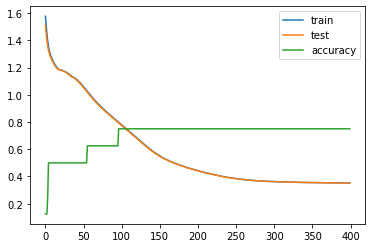

sync baseline 0
baseline stressor 15062
stressor slowBreath 11301
slowBreath stressor 25047
stressor paced 11301
paced stressor 25070
stressor slowBreath 11243
slowBreath stressor 25070
stressor paced 11302
[3, 2, 1, 2, 0, 2, 1, 2]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
train_X shape is (8,)
train_y shape is (8, 4)
test_X shape is (8,)
test_y shape is (8, 4)
Train on 8 samples, validate on 8 samples
Epoch 1/400
 - 16s - loss: 1.3054 - accuracy: 0.5000 - val_loss: 1.2617 - val_accuracy: 0.5000
Epoch 2/400
 - 16s - loss: 1.2617 - accuracy: 0.5000 - val_loss: 1.2414 - val_accuracy: 0.5000
Epoch 3/400
 - 16s - loss: 1.2414 - accuracy: 0.5000 - val_loss: 1.2261 - val_accuracy: 0.5000
Epoch 4/400
 - 16s - loss: 1.2261 - accuracy: 0.5000 - val_loss: 1.2085 - val_accuracy: 0.5000
Epoch 5/400
 - 16s - loss: 1.2085 - accuracy: 0.5000 - val_loss: 1.2058 - val_accuracy: 0.5000
Epoch 6/400
 - 16s - loss: 1.2058 - accu

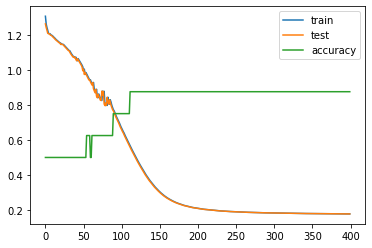

sync baseline 0
baseline stressor 15031
stressor slowBreath 11269
slowBreath stressor 25075
stressor paced 11256
paced stressor 25036
stressor slowBreath 11226
slowBreath stressor 25068
stressor paced 11291
[3, 2, 1, 2, 0, 2, 1, 2]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
train_X shape is (8,)
train_y shape is (8, 4)
test_X shape is (8,)
test_y shape is (8, 4)
Train on 8 samples, validate on 8 samples
Epoch 1/400
 - 16s - loss: 1.4070 - accuracy: 0.2500 - val_loss: 1.3580 - val_accuracy: 0.5000
Epoch 2/400
 - 16s - loss: 1.3580 - accuracy: 0.5000 - val_loss: 1.3200 - val_accuracy: 0.5000
Epoch 3/400
 - 16s - loss: 1.3200 - accuracy: 0.5000 - val_loss: 1.2953 - val_accuracy: 0.5000
Epoch 4/400
 - 16s - loss: 1.2953 - accuracy: 0.5000 - val_loss: 1.2767 - val_accuracy: 0.5000
Epoch 5/400
 - 16s - loss: 1.2767 - accuracy: 0.5000 - val_loss: 1.2619 - val_accuracy: 0.5000
Epoch 6/400
 - 16s - loss: 1.2619 - accu

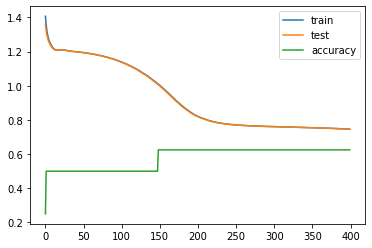

sync baseline 0
baseline stressor 15030
stressor slowBreath 11243
slowBreath stressor 25071
stressor paced 11303
paced stressor 25071
stressor slowBreath 11302
slowBreath stressor 25068
stressor paced 11301
[3, 2, 1, 2, 0, 2, 1, 2]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
train_X shape is (8,)
train_y shape is (8, 4)
test_X shape is (8,)
test_y shape is (8, 4)
Train on 8 samples, validate on 8 samples
Epoch 1/400
 - 16s - loss: 1.4736 - accuracy: 0.1250 - val_loss: 1.4367 - val_accuracy: 0.1250
Epoch 2/400
 - 16s - loss: 1.4367 - accuracy: 0.1250 - val_loss: 1.4059 - val_accuracy: 0.1250
Epoch 3/400
 - 16s - loss: 1.4059 - accuracy: 0.1250 - val_loss: 1.3856 - val_accuracy: 0.1250
Epoch 4/400
 - 16s - loss: 1.3856 - accuracy: 0.1250 - val_loss: 1.3676 - val_accuracy: 0.2500
Epoch 5/400
 - 16s - loss: 1.3676 - accuracy: 0.2500 - val_loss: 1.3548 - val_accuracy: 0.3750
Epoch 6/400
 - 16s - loss: 1.3548 - accu

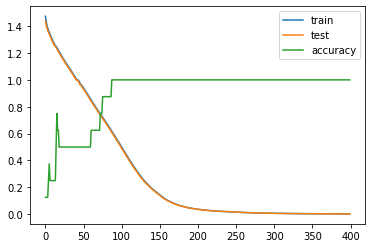

sync baseline 0
baseline stressor 15030
stressor slowBreath 11303
slowBreath stressor 25083
stressor paced 11305
paced stressor 25055
stressor slowBreath 11244
slowBreath stressor 25071
stressor paced 11243
[3, 2, 1, 2, 0, 2, 1, 2]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
train_X shape is (8,)
train_y shape is (8, 4)
test_X shape is (8,)
test_y shape is (8, 4)
Train on 8 samples, validate on 8 samples
Epoch 1/400
 - 16s - loss: 1.6356 - accuracy: 0.1250 - val_loss: 1.5673 - val_accuracy: 0.1250
Epoch 2/400
 - 16s - loss: 1.5673 - accuracy: 0.1250 - val_loss: 1.5209 - val_accuracy: 0.1250
Epoch 3/400
 - 16s - loss: 1.5209 - accuracy: 0.1250 - val_loss: 1.4812 - val_accuracy: 0.1250
Epoch 4/400
 - 16s - loss: 1.4812 - accuracy: 0.1250 - val_loss: 1.4440 - val_accuracy: 0.1250
Epoch 5/400
 - 16s - loss: 1.4440 - accuracy: 0.1250 - val_loss: 1.4110 - val_accuracy: 0.1250
Epoch 6/400
 - 16s - loss: 1.4110 - accu

In [ ]:
for file in files:
    doStuff(file)

In [ ]:
type(train_X[0][0])

In [ ]:
# make a prediction
yhat = model.predict(np.array(test_X))
np.set_printoptions(precision=8)
np.set_printoptions(suppress=True)

print(yhat)

In [ ]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)